03 .Ordination 
==============  
**Overview of relationships between samples and features** 

In [4]:
library(phyloseq)
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(vegan))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(ggplot2))

**Low dimensional representation of relationships between samples/features**  
We are going to follow closely phyloseq's ordination examples (https://joey711.github.io/phyloseq/plot_ordination-examples.html)  
Read data:  


In [5]:
#rds <- readRDS("../../../../../data/tmp/microbiome/quant/qiime2/silva/physeq_filtered.rds")


In [6]:
rds <- readRDS(snakemake@input[[1]])

In [ ]:
df <- data.frame(as(sample_data(rds), "matrix"))
group <- factor(df[,snakemake@params$condition])
cat("Condition: ", snakemake@params$condition, "\n")
cat("Summary:\n")
print(summary(group))
if (!is.null(snakemake@params$ref_level)){
    cat("Setting", snakemake@params$ref_level, "as reference level", "\n")
    group <- relevel(group, ref=snakemake@params$ref_level)
}
df[,"Sample_Group"] <- group
sample_data(rds) <- df


In [19]:
df <- data.frame(as(sample_data(rds), "matrix"))
batch <- NULL
if (!is.null(snakemake@params$batch)){
    print(cat("\nBatch factor given as: ", snakemake@params$batch, "\n"))
    batch <- factor(snakemake@params$batch)
    print(summary(batch))
    df[,snakemake@params$batch] <- batch
    sample_data(rds) <- df
}


Condition:  Sample_Group 
Summary:
     HC     PPI PPI_FGP 
     11       9      16 
Setting HC as reference level 

Sample subset exracted from Sample_Biosource == saft 

We are now using 36 samples

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 821 taxa and 36 samples ]
sample_data() Sample Data:       [ 36 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 821 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 821 tips and 814 internal nodes ]
refseq()      DNAStringSet:      [ 821 reference sequences ]

---------------

Next step is to agglomerate at a specific taxon level 

In [15]:
if (!is.null(snakemake@params$taxrank)){
    cat("Taxrank: ", snakemake@params$taxrank, "\n")
    if (require(speedyseq)){
        rds <- speedyseq::tax_glom(rds, taxrank=snakemake@params$taxrank)
    } else{
        rds <- tax_glom(rds, taxrank=snakemake@params$taxrank)
    } 
} else{
    cat("Taxrank: None, Data is not aggregated. Each feature is an ASV (specific sequence)", "\n")
}
rds

Taxrank: None, Data is not aggregated. Each feature is an ASV (specific sequence) 


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 821 taxa and 36 samples ]
sample_data() Sample Data:       [ 36 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 821 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 821 tips and 814 internal nodes ]
refseq()      DNAStringSet:      [ 821 reference sequences ]

---------------

It is normal to filter a bit more aggresive in dimension reduction methods (as compared to diff. epxrs for instance) as we are looking for variance across all groups to identify global patterns. Also, we may work on a subset and thus prevalence thresholds may have changed.

In [29]:

if (!is.null(snakemake@params$independent_filtering)){
    if (snakemake@params$independent_filtering == TRUE){
        wh0 = genefilter_sample(rds, filterfun_sample(function(x) x > 5), A=0.25*nsamples(rds))
        rds = prune_taxa(wh0, rds)
        phylum.sum = tapply(taxa_sums(rds), tax_table(rds)[, "Phylum"], sum, na.rm=TRUE)
        top6phyla = names(sort(phylum.sum, TRUE))[1:6]
        rds = prune_taxa((tax_table(rds)[, "Phylum"] %in% top6phyla), rds)
    }
}

cat("After filtering:\n")
rds

After filtering:


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 205 taxa and 36 samples ]
sample_data() Sample Data:       [ 36 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 205 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 205 tips and 202 internal nodes ]
refseq()      DNAStringSet:      [ 205 reference sequences ]

We like to start out with equal impact of all samples and start out with a normalization to equal count (Counts per million)

In [17]:
rds = transform_sample_counts(rds, function(x) 1E6 * x/sum(x))

In [ ]:
#https://github.com/LieberInstitute/jaffelab
cleaningY <- function(y, mod, P) {
    stopifnot(P <= ncol(mod))
    Hat <- solve(t(mod) %*% mod) %*% t(mod)
    ## For dealing with NAs
    ## https://stackoverflow.com/questions/16535084/matrix-multiplication-with-scattered-na-values
    ty <- t(y)
    ty[is.na(ty)] <- 0
    beta <- (Hat %*% ty)
    ## Note that y might still have the NAs, and NA - a number = NA
    ## so there's no need to reset the NAs back on cleany
    cleany <- y - t(as.matrix(mod[, -c(seq_len(P))]) %*% beta[-seq_len(P), ])
    return(cleany)
    }

if (!is.null(snakemake@params$block)){
    df <- data.frame(as(sample_data(rds), "matrix"))
    mod <- with(df, model.matrix(~ snakemake@params$condition + snakemake@params$batch))
    Y <- t(as(otu_table(rds), "matrix"))
    Yclean <- cleaningY(Y, mod, P=ncol(mod))
    otu_table(rds) <- Yclean
    }


--------------------


Our default ordination methods is using Bray-Curtis distance (phylogenetic distance) and Non-negative multidimensional scaling (NMDS) as the dimension reduction method.

In [18]:
GP.ord <- ordinate(rds, "NMDS", "bray")

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1997037 
Run 1 stress 0.2328027 
Run 2 stress 0.1997037 
... Procrustes: rmse 3.727728e-05  max resid 0.0001223678 
... Similar to previous best
Run 3 stress 0.233551 
Run 4 stress 0.2387247 
Run 5 stress 0.2083979 
Run 6 stress 0.210115 
Run 7 stress 0.199656 
... New best solution
... Procrustes: rmse 0.01588642  max resid 0.0838528 
Run 8 stress 0.2085257 
Run 9 stress 0.2145015 
Run 10 stress 0.2141249 
Run 11 stress 0.1997037 
... Procrustes: rmse 0.01588218  max resid 0.08386982 
Run 12 stress 0.3964296 
Run 13 stress 0.2367641 
Run 14 stress 0.2237325 
Run 15 stress 0.1997037 
... Procrustes: rmse 0.01589291  max resid 0.08385033 
Run 16 stress 0.2368311 
Run 17 stress 0.249399 
Run 18 stress 0.2085265 
Run 19 stress 0.2145014 
Run 20 stress 0.253712 
*** No convergence -- monoMDS stopping criteria:
    20: stress ratio > sratmax


We start out by looking at the relations between taxa to look for any irregular patterns. Each point is either an OTU/ASV or summarized to a specific taxonomic level given by model name. 

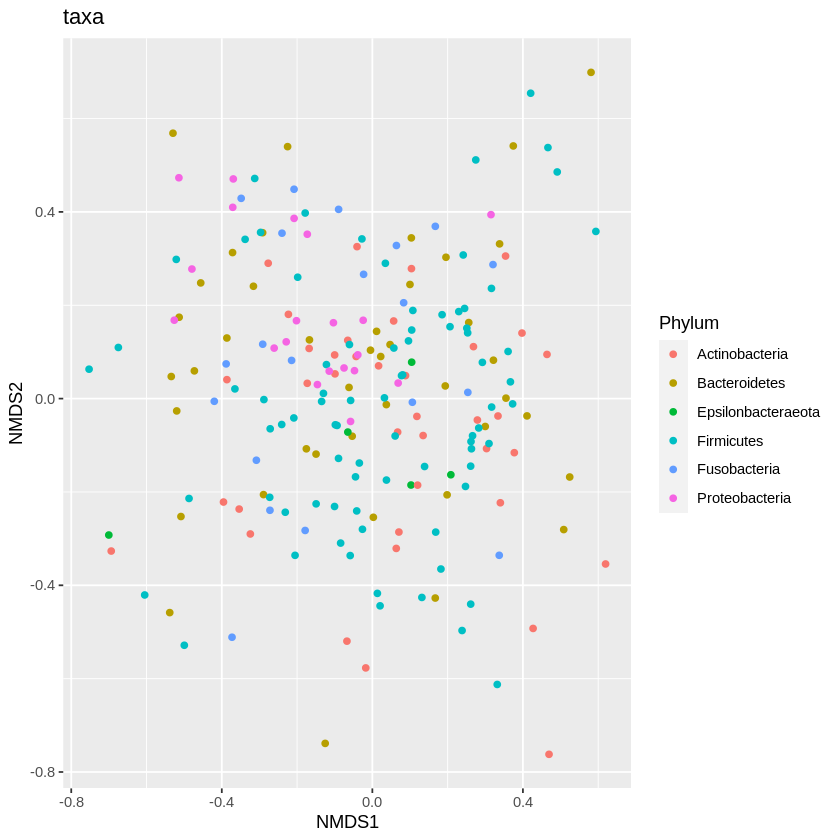

In [19]:
p1 = plot_ordination(rds, GP.ord, type="taxa", color="Phylum", title="taxa")
print(p1)

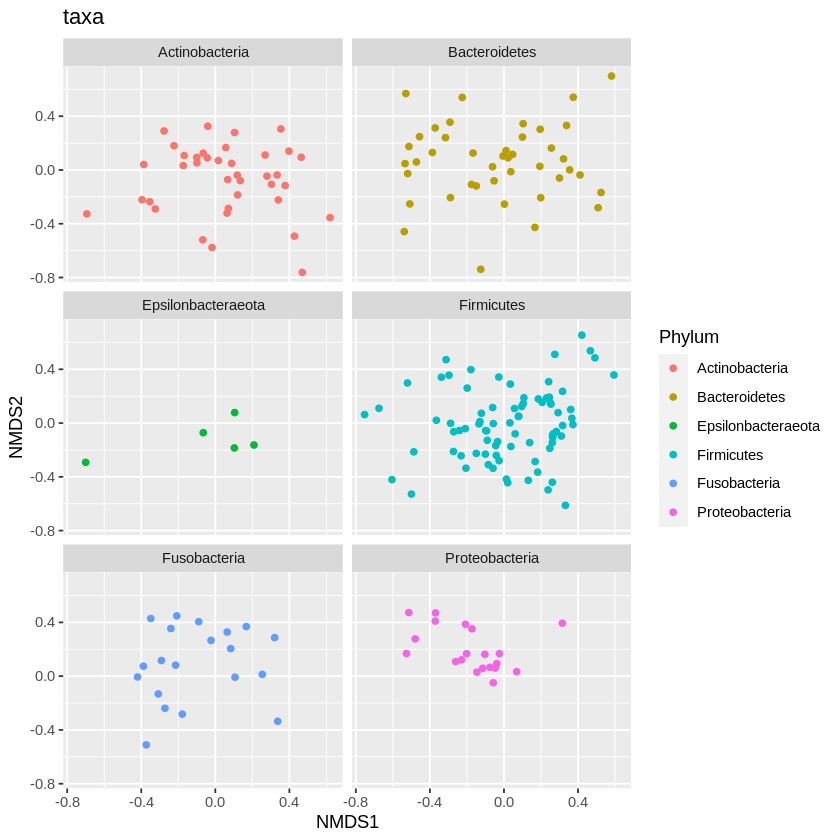

In [20]:
p1 + facet_wrap(~Phylum, 3)

Do the same figures for samples. Each point is one sample.

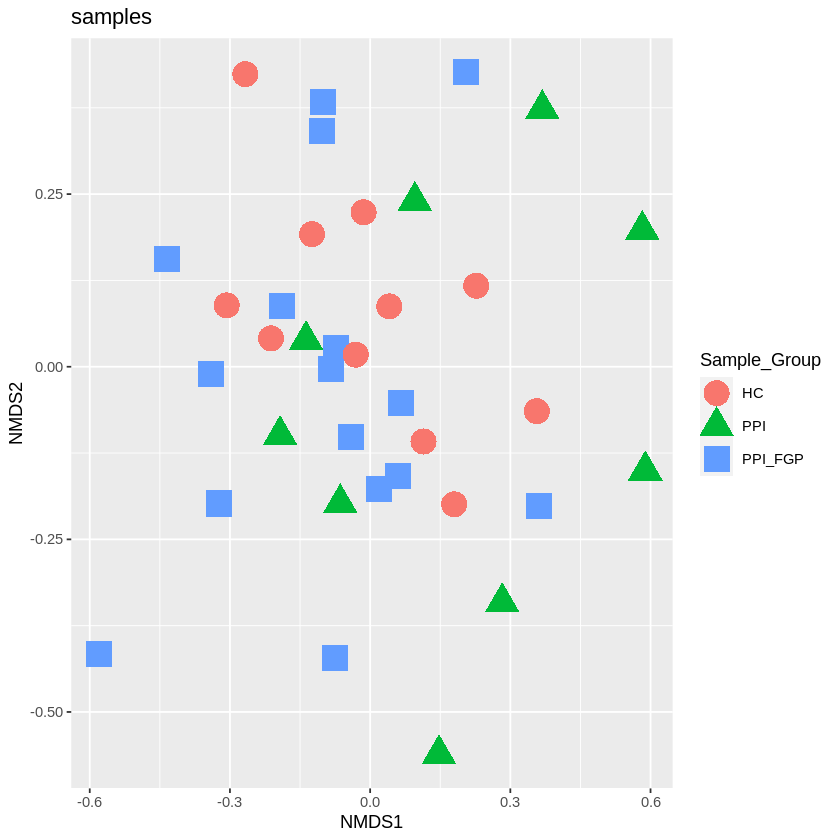

In [21]:
p2 = plot_ordination(rds, GP.ord, type="samples", color="Sample_Group", shape="Sample_Group") 
p2 + geom_point(size=7) + ggtitle("samples")

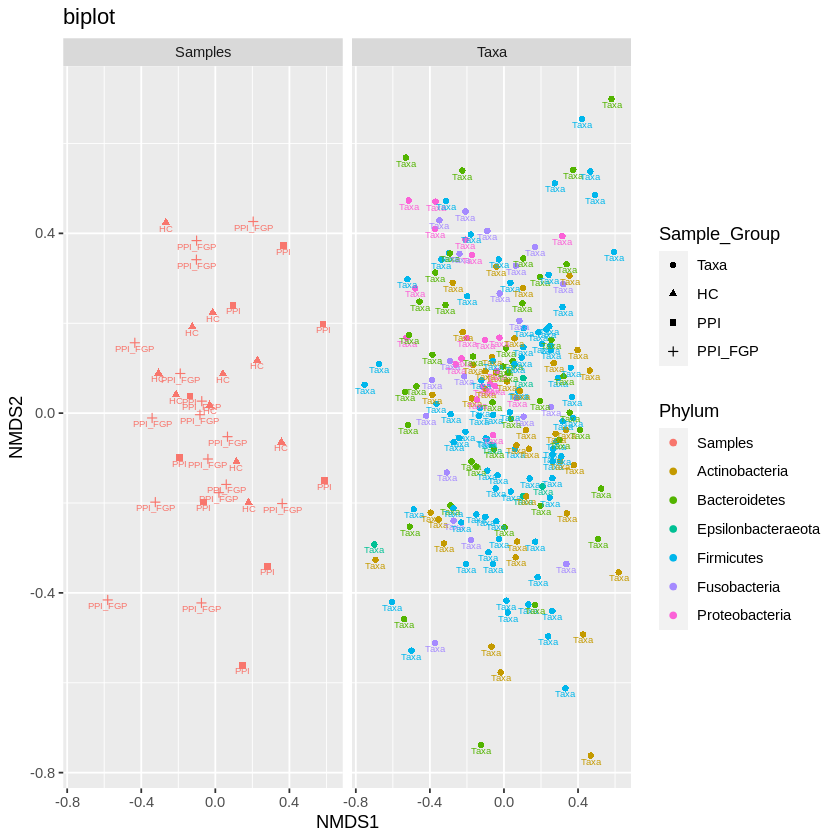

In [22]:
p4 = plot_ordination(rds, GP.ord, type="split", color="Phylum", shape="Sample_Group", label="Sample_Group", title="biplot") 
p4

Lets do a summary of all the available decompositions in phyloseq:

In [23]:
dist = "bray"
ord_meths = c("DCA", "CCA", "RDA", "DPCoA", "NMDS", "MDS", "PCoA")
plist = llply(as.list(ord_meths), function(i, physeq, dist){
        ordi = ordinate(rds, method=i, distance=dist)
        plot_ordination(rds, ordi, "samples", color="Sample_Group")
}, rds, dist)
names(plist) <- ord_meths

pdataframe = ldply(plist, function(x){
    df = x$data[, 1:2]
    colnames(df) = c("Axis_1", "Axis_2")
    return(cbind(df, x$data))
})
names(pdataframe)[1] = "method"

Warning message in is.euclid(patristicDist):
“Zero distance(s)”
Warning message in is.euclid(dis):
“Zero distance(s)”
Warning message:
“non-unique values when setting 'row.names': ”
Species coordinates not found directly in ordination object. Attempting weighted average (`vegan::wascores`)



Square root transformation
Wisconsin double standardization
Run 0 stress 0.1997037 
Run 1 stress 0.208398 
Run 2 stress 0.2141293 
Run 3 stress 0.2434118 
Run 4 stress 0.2218398 
Run 5 stress 0.2332577 
Run 6 stress 0.1996551 
... New best solution
... Procrustes: rmse 0.01586471  max resid 0.08375706 
Run 7 stress 0.2199929 
Run 8 stress 0.2147968 
Run 9 stress 0.2177478 
Run 10 stress 0.1996558 
... Procrustes: rmse 0.0001677879  max resid 0.0007700649 
... Similar to previous best
Run 11 stress 0.2576948 
Run 12 stress 0.2205631 
Run 13 stress 0.2145013 
Run 14 stress 0.2632562 
Run 15 stress 0.2145016 
Run 16 stress 0.2456707 
Run 17 stress 0.1997037 
... Procrustes: rmse 0.01586457  max resid 0.08374955 
Run 18 stress 0.2141273 
Run 19 stress 0.2101891 
Run 20 stress 0.1997037 
... Procrustes: rmse 0.01586357  max resid 0.08378347 
*** Solution reached


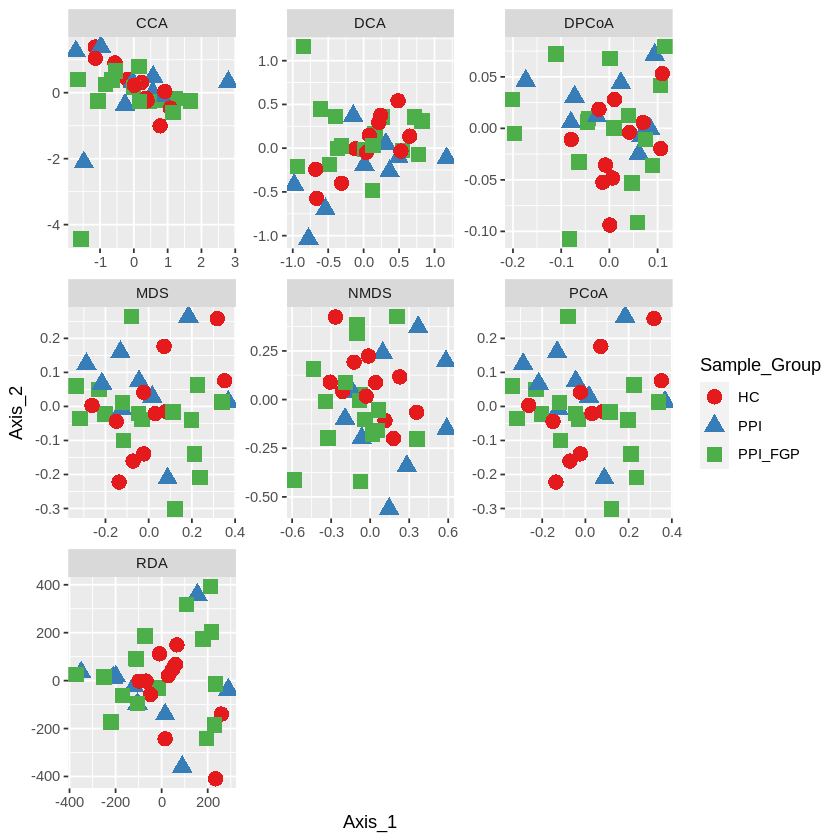

In [24]:
p = ggplot(pdataframe, aes(Axis_1, Axis_2, color=Sample_Group, shape=Sample_Group, fill=Sample_Group))
p = p + geom_point(size=4)
p = p + facet_wrap(~method, scales="free")
p = p + scale_fill_brewer(type="qual", palette="Set1")
p = p + scale_colour_brewer(type="qual", palette="Set1")
p

An example with weighted Unifrac (can be a bit more unstable than Bray) using Principal Coordinate Analysis

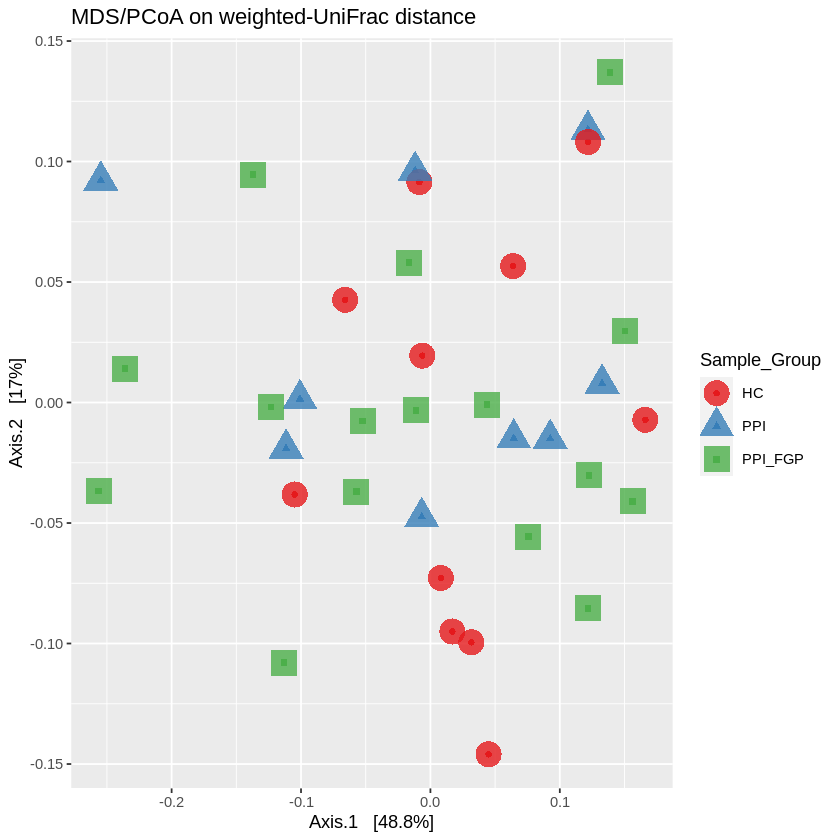

In [25]:
ordu = ordinate(rds, "PCoA", "unifrac", weighted=TRUE)
p5 <- plot_ordination(rds, ordu, color="Sample_Group", shape="Sample_Group")
p5 = p5 + geom_point(size=7,alpha=0.8)
p5 = p5 + scale_colour_brewer(type="qual", palette="Set1")
p5 + ggtitle("MDS/PCoA on weighted-UniFrac distance")

----------------------

Lets check for significance of our *condition* in the low dimensional space defined bu the ordination. Are the groups signficant different from eachother? For this we are using permuation ANOVA from the *vegan* package (adonis). We will extract the two first dimensions (PC) and use this for signficance testing.

In [26]:
PC <- ordu$vectors[,1:2]
PC <- GP.ord$points
X <- cbind(PC, df)
adonis(PC ~ Sample_Group, data = X, method='eu')


Call:
adonis(formula = PC ~ Sample_Group, data = X, method = "eu") 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

             Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)  
Sample_Group  2    0.5729 0.28645  2.3932 0.12667  0.057 .
Residuals    33    3.9499 0.11969         0.87333         
Total        35    4.5228                 1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Write the default dimred coordinates to file

In [27]:
write.table(X, file=snakemake@output[[1]])

In [30]:
cat("Wrote:", snakemake@output[[1]])

Wrote: data/tmp/microbiome/analysis/GCF-2019-658-juice/ordinations.tsv